In [105]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

In [8]:



Nx = 128

xx, yy = np.meshgrid(Nx,Nx)
print(zz)

[[0.71783409 0.04785513 0.94447198 ... 0.94314901 0.0553212  0.58061716]
 [0.80740467 0.37524674 0.70494906 ... 0.07682499 0.92238213 0.10152035]
 [0.84784075 0.64763001 0.47386936 ... 0.67068954 0.64697153 0.10123259]
 ...
 [0.17945545 0.92750699 0.25229372 ... 0.75069465 0.2613832  0.31007265]
 [0.43957298 0.8679642  0.35557802 ... 0.39390598 0.57252301 0.0169329 ]
 [0.33939998 0.69113803 0.71380873 ... 0.02252953 0.01450031 0.39113085]]


In [86]:
#     topleft = a[-1,1]
#     topmid = a[0,1]
#     topright = a[1,1]
    
#     midleft = a[-1,0]
#     midmid = a[0,0]
#     midright = a[1,0]
    
#     botleft = a[-1,-1]
#     botmid = a[0,-1]
#     botright = a[1,-1]

In [106]:
@nb.stencil
def kernel1(a, corr):
    c1, c2, c3, c4 = corr
    topleft = a[1,-1]
    topmid = a[1,0]
    topright = a[1,1]
    
    midleft = a[0,-1]
    midmid = a[0,0]
    midright = a[0,1]
    
    botleft = a[-1,-1]
    botmid = a[-1,0]
    botright = a[-1,1]
    
    c1_bl = c1[0,0]
    c1_br = c1[0,1]
    c1_tl = c1[1,0]
    c1_tr = c1[1,1]
    
    Dx_tl = 0.5 * (topmid   - topleft + midmid   - midleft)
    Dx_tr = 0.5 * (topright - topmid  + midright - midmid )
    Dx_bl = 0.5 * (botmid   - botleft + midmid   - midleft)
    Dx_br = 0.5 * (botright - botmid  + midright - midmid )

    Dy_tl = 0.5 * (midmid   - topmid   + midleft - topleft)
    Dy_tr = 0.5 * (midright - topright + midmid  - topmid )
    Dy_bl = 0.5 * (botmid   - midmid   + botleft - midleft)
    Dy_br = 0.5 * (botright - midright + botmid  - midmid )
    
    Dxx = 0.5 * (Dx_tr - Dx_tl + Dx_br - Dx_bl)
    Dyy = 0.5 * (Dy_br - Dy_tr + Dy_bl - Dy_tl)
    Dyx = 0.5 * (Dy_br - Dy_bl + Dy_tr - Dy_tl)
    Dxy = 0.5 * (Dx_br - Dx_tr + Dy_bl - Dx_tl)
    
    return (Dxx + Dyy + Dyx + Dxy)

@nb.stencil
def kernel2(a):
    return (a[0, 1] + a[1, 0] + a[0, -1] + a[-1, 0] - 4.0 * a[0, 0])

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.93197483  0.53101148 -0.49379799 -0.36685163  0.0154645
   0.88374553  0.0846834  -0.39515766  0.        ]
 [ 0.         -0.30388205  0.49981076 -0.3232148   0.16515971  0.51846957
  -0.06862451 -0.00141823 -0.84673293  0.        ]
 [ 0.          0.02514404  0.77405488  0.74002185  0.15287068  0.64931092
   0.38692438  0.60045002  0.07443422  0.        ]
 [ 0.         -0.25645163 -0.70695656 -0.24803777 -0.68589025  0.10813759
  -0.05859939 -0.30566445 -0.76560589  0.        ]
 [ 0.         -0.37377059  0.49278487  0.32657142  0.21642514 -0.06073053
   0.26996271 -0.49797162 -0.27184671  0.        ]
 [ 0.         -0.42421971  0.53630134 -0.54410755  0.73981932  0.46093549
   0.53449053 -0.59733802  0.74493922  0.        ]
 [ 0.          0.48932431  0.42552396 -1.11626804 -0.9253024   0.32569448
   0.1626621   0.07154697 -0.22614225  0.        ]
 [ 0.    

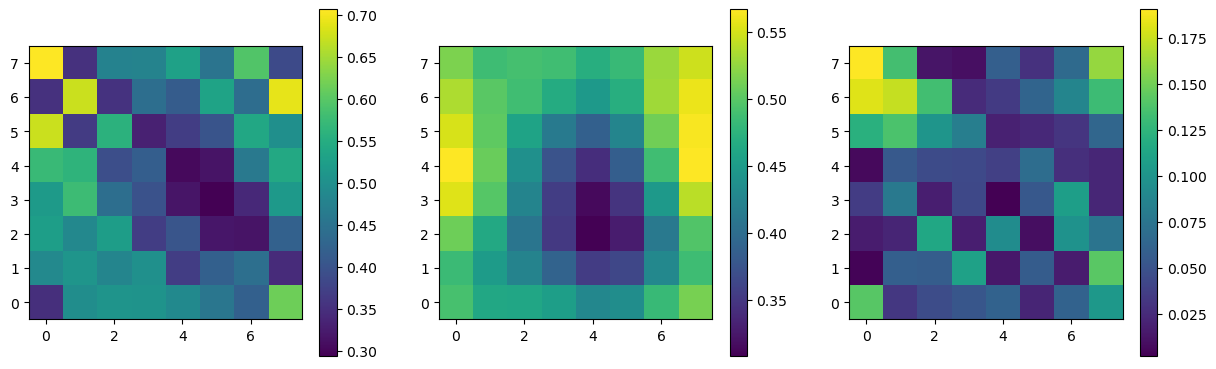

In [110]:
i1 = (slice(1,-1),slice(1,-1))
Nx = 10
dt = 0.1
np.random.seed(555)
zz = np.random.random((Nx,Nx))
zz1 = np.copy(zz)

zz = np.pad(zz[i1], ((1,1),(1,1)), mode='wrap')
zz1 = np.pad(zz1[i1], ((1,1),(1,1)), mode='wrap')

@nb.njit(cache=True)
def looper(zz, zz1, dt):
    for _ in range(10):
        c1 = np.random.random((Nx,Nx))
        c2 = np.random.random((Nx,Nx))
        c3 = np.random.random((Nx,Nx))
        c4 = np.random.random((Nx,Nx))
        corr = (c1,c2,c3,c4)
        zz = periodic(zz)
        zz1 = periodic(zz1)
        zz = zz + dt * kernel1(zz, corr)
        zz1 = zz1 + dt * kernel2(zz1)
        
    return zz, zz1

@nb.njit
def periodic(arr):
    arr[0,:] = arr[-2,:]
    arr[-1,:] = arr[1,:]
    arr[:,0] = arr[:,-2]
    arr[:,-1] = arr[:,1]
    
    return arr
    
zz, zz1 = looper(zz, zz1, dt)

fig, ax = plt.subplots(1,3, figsize=(15,4.5))
im0 = ax[0].imshow(zz[i1], origin='lower')
im1 = ax[1].imshow(zz1[i1], origin='lower')
im2 = ax[2].imshow(np.abs(zz[i1] - zz1[i1]), origin='lower')

plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
plt.show()

In [59]:
@nb.stencil
def _smooth(x):
    return (x[-1, -1] + x[-1, 0] + x[-1, 1] +
            x[ 0, -1] + x[ 0, 0] + x[ 0, 1] +
            x[ 1, -1] + x[ 1, 0] + x[ 1, 1]) // 9

In [60]:
x = np.ones((100, 100))

%timeit _smooth(x)

249 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
x = np.random.random((Nx,Nx))

@nb.njit
def smooth(x):
    for _ in range(10):
        x = x + kernel1(x)
    return kernel1(x)

%timeit smooth(x)

1.02 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
@nb.stencil
def kernel1(a):
    return 0.25 * (a[0, 1] + a[1, 0] + a[0, -1] + a[-1, 0])


In [102]:
input_arr = np.arange(100).reshape((10, 10))
print(input_arr.shape)

(10, 10)


In [103]:
output_arr = kernel1(input_arr)
print(output_arr.shape)

(10, 10)


In [101]:
print(output_arr)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 11. 12. 13. 14. 15. 16. 17. 18.  0.]
 [ 0. 21. 22. 23. 24. 25. 26. 27. 28.  0.]
 [ 0. 31. 32. 33. 34. 35. 36. 37. 38.  0.]
 [ 0. 41. 42. 43. 44. 45. 46. 47. 48.  0.]
 [ 0. 51. 52. 53. 54. 55. 56. 57. 58.  0.]
 [ 0. 61. 62. 63. 64. 65. 66. 67. 68.  0.]
 [ 0. 71. 72. 73. 74. 75. 76. 77. 78.  0.]
 [ 0. 81. 82. 83. 84. 85. 86. 87. 88.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
